<a href="https://colab.research.google.com/github/wonkyunglee/capsule_net/blob/master/capsule_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My\ Drive/SLVLab/paper_reproducing/capsule_net/
!ls

/content/gdrive/My Drive/SLVLab/paper_reproducing/capsule_net
capsule_net.ipynb  checkpoints	data


In [0]:

transform = transforms.Compose(
    [transforms.RandomCrop(28, padding=2, fill=0),
     transforms.ToTensor()]
)


train_dataset = dsets.MNIST(root='./data/MNIST/', 
                            train=True, 
                            transform=transform,
                            download=True, )

test_dataset = dsets.MNIST(root='./data/MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())

In [0]:
batch_size = 100
num_epochs = 100


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Build Model

In [0]:
class ReLUConv1(nn.Module):
    '''
    Input: 28x28 image (one color channel).
    Output: 20x20x256 tensor.
    '''
    def __init__(self):
        super(ReLUConv1, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1, padding=0)
        self.relu1 = nn.ReLU()


    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        assert out.shape == (batch_size, 256, 20, 20), out.shape    
        return out

      
class Caps(nn.Module):
    '''
    Parent module for capsule class
    '''
    def __init__(self):
        super(Caps, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def squash(self, x):
        squared_norm = (x ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        orientation = x / torch.sqrt(squared_norm)
        squashed = scale * orientation
        return squashed
    
    
class PrimaryCaps(Caps):
  
    def __init__(self):
        super(PrimaryCaps, self).__init__()
        self.capsule = nn.Conv2d(in_channels=256, out_channels=8, kernel_size=9, stride=2, padding=0)


    def forward(self, x):
        out = self.capsule(x)
        out = self.squash(out)
        assert out.shape == (batch_size, 8, 6, 6), out.shape
        return out
      
      
class PrimaryCapsLayer(nn.Module):
    '''
    Input: 20x20x256 tensor
    Output: 6x6x8x32 tensor.
    '''
    def __init__(self):
        super(PrimaryCapsLayer, self).__init__()
        self.caps_num = 32
        self.caps_list = nn.ModuleList([PrimaryCaps() for i in range(self.caps_num)])


    def forward(self, x):
        out = [caps(x) for caps in self.caps_list]
        out = torch.stack(out, -1)
        assert out.shape == (batch_size, 8, 6, 6, self.caps_num), out.shape
        
        return out
      

class DigitCaps(Caps):
  
    def __init__(self):
        super(DigitCaps, self).__init__()
        self.caps_num = 32
        self.last_dim = 16
        self.r = 3 # routing iteration number
        self.weight_matrices = nn.ModuleList(
            [nn.Linear(in_features=8, out_features=16, bias=False) for i in range(6*6*32)])
                

    def forward(self, x):
        # reshape and split
        x = x.transpose(1, 3)
        x = x.transpose(3, 4)
        assert x.shape == (batch_size, 6, 6, self.caps_num, 8), x.shape
        x = torch.reshape(x, (batch_size, 6 * 6 * self.caps_num, 8))
        assert x.shape == (batch_size, 6 * 6 * self.caps_num, 8), x.shape
        splited_list = torch.split(x, 6 * 6 * self.caps_num, dim=1)
        
        # get prediction vector
        prediction_vectors = [weight_matrix(splited) for splited, weight_matrix in zip(splited_list, self.weight_matrices)]
        
        # routing
        v = self.routing(prediction_vectors, self.r)
        
        return v

      
    def routing(self, prediction_vectors, r):
        u = torch.cat(prediction_vectors, dim=1)
        assert u.shape == (batch_size, 6*6*self.caps_num, 16), u.shape
        
        # log prior
        b_vec = torch.zeros(batch_size, 6*6*self.caps_num).to(self.device)
        
        for _ in range(r):
            c = nn.Softmax()(b_vec).to(self.device)
            c_vec = c.view(*c.shape, 1) # coupling coefficient
            s = (c_vec * u).sum(-2) # linear combination, broadcasting
            assert s.shape == (batch_size, 16), s.shape
            v = self.squash(s) # output vector
            
            v_reshaped = torch.reshape(v, (batch_size, 1, 16))
            agreement = (u * v_reshaped).sum(-1) # dot product, broadcasting
            assert agreement.shape == b_vec.shape, agreement.shape
            # log prior + log likelihood
            b_vec = b_vec + agreement
        
        v_ret = v_reshaped.view(batch_size, 16, 1)
        return v_ret

      
class DigitCapsLayer(nn.Module):
    '''
    Input: 6x6x8x32 tensor.
    Output: 16x10 matrix.
    '''
    def __init__(self):
        super(DigitCapsLayer, self).__init__()
        self.class_num = 10
        self.caps_list = nn.ModuleList([DigitCaps() for i in range(self.class_num)])


    def forward(self, x):
        out = [caps(x) for caps in self.caps_list]
        out = torch.cat(out, dim=2)
        assert out.shape == (batch_size, 16, self.class_num), out.shape
        
        return out


class CapsNet(nn.Module):
    
    def __init__(self, decode=True):
        super(CapsNet, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.class_num = 10
        self.caps_net = nn.Sequential(
            ReLUConv1(),
            PrimaryCapsLayer(),
            DigitCapsLayer()
        )
        if decode:
            self.decoder = nn.Sequential(
                nn.Linear(16, 512),
                nn.ReLU(),
                nn.Linear(512, 1024),
                nn.ReLU(),
                nn.Linear(1024, 784),
                nn.Sigmoid()
            )

    def forward(self, images, dense_label=None):
        codes = self.caps_net(images)
        scores = codes.pow(2).sum(dim=1, keepdim=False)
        assert scores.shape == (batch_size, 10), scores.shape
        reconstructed = None
        if decode:
            assert dense_label is not None
            dense_label = torch.reshape(dense_label, (batch_size, 1, 10))
            selected_codes = codes * dense_label
            selected_codes = selected_codes.sum(2)
            assert selected_codes.shape == (batch_size, 16), selected_codes.shape
            reconstructed = self.decoder(selected_codes)
        
        return codes, scores, reconstructed

    


In [0]:
class MarginLoss(nn.Module):

    def __init__(self):
        super(MarginLoss, self).__init__()
        self.m_plus = 0.9
        self.m_minus = 0.1
        self.ratio = 0.5
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(self.device)
        
    def forward(self, norm, dense_label):
        assert norm.shape == (batch_size, 10), norm.shape
        assert dense_label.shape == (batch_size, 10), dense_label.shape
        true_loss = nn.ReLU()(self.m_plus - norm).pow(2).to(self.device)
        false_loss = nn.ReLU()(norm - self.m_minus).pow(2).to(self.device)
        total_loss = dense_label * true_loss + self.ratio * (1 - dense_label) * false_loss
        loss = total_loss.sum() / batch_size
        return loss
        
        
        
class ReconstructionLoss(nn.Module):

    def __init__(self):
        super(ReconstructionLoss, self).__init__()
        
    def forward(self, reconstructed, image):
        
        reshaped_image = torch.reshape(image, (batch_size, -1))
        assert reconstructed.shape == reshaped_image.shape
        
        loss = nn.MSELoss(reduction='sum')(reconstructed, reshaped_image) # sum of squared loss
        return loss

## Decode Version

In [118]:
reconstruction_loss_ratio = 0.0005
decode = True


model = CapsNet(decode)
margin_loss = MarginLoss()

if decode:
    reconstruction_loss = ReconstructionLoss()

num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


cuda:0
The number of parameters :  8141840


CapsNet(
  (caps_net): Sequential(
    (0): ReLUConv1(
      (cnn1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
      (relu1): ReLU()
    )
    (1): PrimaryCapsLayer(
      (caps_list): ModuleList(
        (0): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (1): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (2): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (3): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (4): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (5): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (6): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (7): PrimaryCaps(
          (capsule):

In [0]:
optimizer = torch.optim.Adam(model.parameters()) 
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=)

In [0]:
# Load model if it is ready.
# load_epoch = 3000 
# checkpoint = torch.load('checkpoints/decode_model_%d.pt'%load_epoch)
# model.load_state_dict(checkpoint)

In [121]:
def to_one_hot(labels, num_classes, device):
    y = torch.eye(num_classes).to(device)
    return y[labels] 

  
def save_model(model, iter):
  if decode:
      model_path = 'checkpoints/decode_model_%d.pt'%iter
  else:
      model_path = 'checkpoints/model_%d.pt'%iter
  torch.save(model.state_dict(), model_path)
  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        one_hot_labels = to_one_hot(labels, 10, device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        codes, scores, reconstructed = model(images, one_hot_labels)

        # Calculate Loss: softmax --> cross entropy loss
        loss = margin_loss(scores, one_hot_labels)
        if decode:
            loss = loss + reconstruction_loss_ratio * reconstruction_loss(reconstructed, images)
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % 100 == 0:
          print(iter, loss.item())

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                one_hot_labels = to_one_hot(labels, 10, device)
                
                # Forward pass only to get logits/output
                codes, scores, reconstructed = model(images, one_hot_labels)

                # Get predictions from the maximum value
                _, predicted = torch.max(scores.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            
        if iter % 3000 == 0:
            save_model(model, iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


100 2.9982032775878906
200 2.9169504642486572
300 2.668569326400757
400 2.56005859375
500 2.387420415878296
Iteration: 500. Loss: 2.387420415878296. Accuracy: 95.49
600 2.316917896270752
700 2.2093570232391357
800 2.209703207015991
900 2.114027976989746
1000 2.045044183731079
Iteration: 1000. Loss: 2.045044183731079. Accuracy: 97.58
1100 1.8888328075408936
1200 1.8724550008773804
1300 1.9292221069335938
1400 1.81493079662323
1500 1.6958492994308472
Iteration: 1500. Loss: 1.6958492994308472. Accuracy: 97.99
1600 1.7893335819244385
1700 1.739061713218689
1800 1.6337605714797974
1900 1.5926648378372192
2000 1.5005948543548584
Iteration: 2000. Loss: 1.5005948543548584. Accuracy: 98.2
2100 1.5747315883636475
2200 1.6139841079711914
2300 1.5598262548446655
2400 1.5047128200531006
2500 1.5262914896011353
Iteration: 2500. Loss: 1.5262914896011353. Accuracy: 98.55
2600 1.340380072593689
2700 1.4225666522979736
2800 1.234879493713379
2900 1.352110505104065
3000 1.5024378299713135
Iteration: 3000

KeyboardInterrupt: ignored

## Code perturbation and Reconstruction Test

In [144]:
model.eval()
# Iterate through test dataset
for images, labels in test_loader:
    break

images = images.to(device)
labels = labels.to(device)
one_hot_labels = to_one_hot(labels, 10, device)

# Forward pass only to get logits/output
codes, scores, reconstructed = model(images, one_hot_labels)

# Get predictions from the maximum value
_, predicted = torch.max(scores.data, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


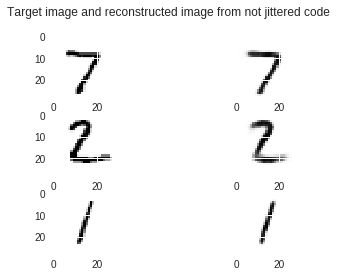

In [145]:
f, axarr = plt.subplots(3, 2, sharey=True)
f.suptitle('Target image and reconstructed image from not jittered code')
for idx in range(3):
    axarr[idx,0].imshow(images[idx].cpu().numpy().reshape(28,28))
    axarr[idx,1].imshow(reconstructed[idx].cpu().detach().numpy().reshape(28,28))
f.subplots_adjust(hspace=0.3)


In [137]:
jitter_list = np.linspace(-0.25, 0.25, 11)
print(jitter_list)

array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
        0.2 ,  0.25])

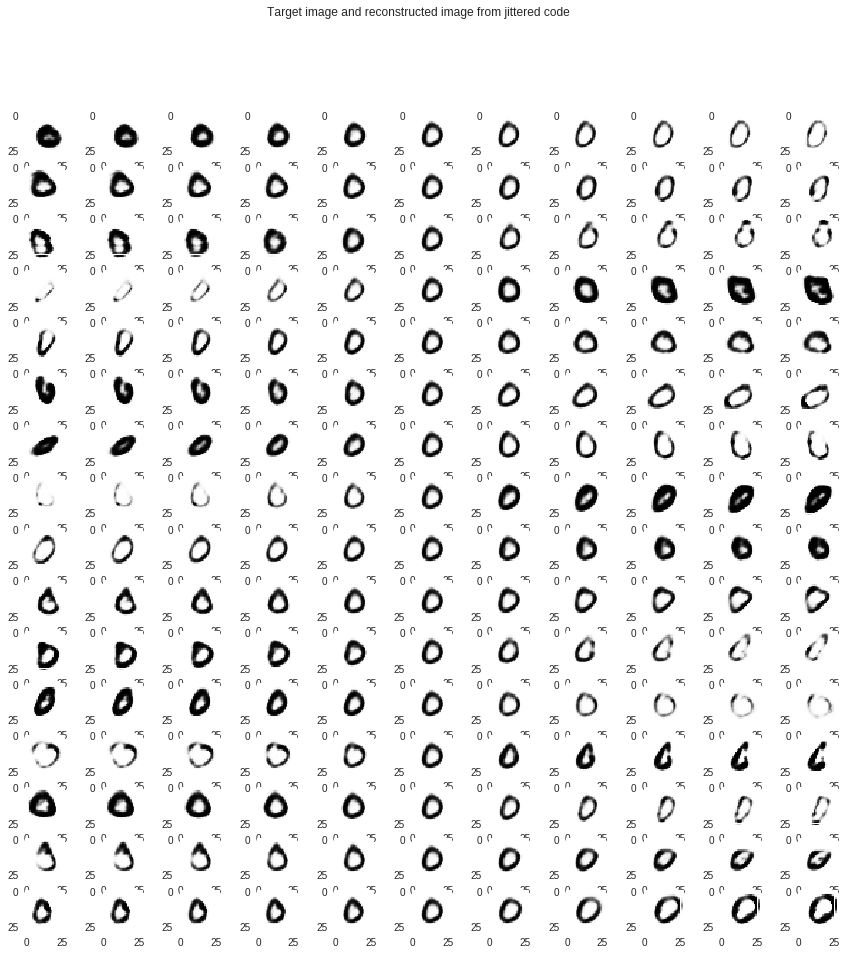

In [155]:
idx = 3


f, axarr = plt.subplots(16, 11, figsize=(15,15))
f.suptitle('Target image and reconstructed image from jittered code')
for dim in range(16):
    for i, jit in enumerate(jitter_list):
        jittered_code = codes[idx][:, labels[idx]].reshape(1, -1).cpu().detach().numpy().copy()
#         print('before',jittered_code[0])
        jittered_code[0][dim] += jit
#         print('after',jittered_code[0])
        reconstructed = model.decoder(torch.Tensor(jittered_code).to(device))
        axarr[dim, i].imshow(reconstructed[0].cpu().detach().numpy().reshape(28,28))
f.subplots_adjust(hspace=0.3)


## Not Decode Version

In [0]:
reconstruction_loss_ratio = 0.0005
decode = False


model = CapsNet(decode)
margin_loss = MarginLoss()

if decode:
    reconstruction_loss = ReconstructionLoss()

num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


cuda:0
The number of parameters :  6988544


CapsNet(
  (caps_net): Sequential(
    (0): ReLUConv1(
      (cnn1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
      (relu1): ReLU()
    )
    (1): PrimaryCapsLayer(
      (caps_list): ModuleList(
        (0): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (1): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (2): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (3): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (4): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (5): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (6): PrimaryCaps(
          (capsule): Conv2d(256, 8, kernel_size=(9, 9), stride=(2, 2))
        )
        (7): PrimaryCaps(
          (capsule):

In [0]:
optimizer = torch.optim.Adam(model.parameters()) 

In [0]:
def to_one_hot(labels, num_classes, device):
    y = torch.eye(num_classes).to(device)
    return y[labels] 

  
def save_model(model, iter):
    if decode:
        model_path = 'checkpoints/decode_model_%d.pt'%iter
    else:
        model_path = 'checkpoints/model_%d.pt'%iter
    torch.save(model.state_dict(), model_path)
  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        one_hot_labels = to_one_hot(labels, 10, device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        codes, scores, reconstructed = model(images, one_hot_labels)

        # Calculate Loss: softmax --> cross entropy loss
        loss = margin_loss(scores, one_hot_labels)
        if decode:
            loss = loss + reconstruction_loss_ratio* reconstruction_loss(reconstructed, images)
        
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % 100 == 0:
          print(iter, loss.item())

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                one_hot_labels = to_one_hot(labels, 10, device)
                
                # Forward pass only to get logits/output
                codes, scores, reconstructed = model(images, one_hot_labels)

                # Get predictions from the maximum value
                _, predicted = torch.max(scores.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            
        if iter % 3000 == 0:
            save_model(model, iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


100 0.2358427494764328
200 0.07700761407613754
300 0.0479707270860672
400 0.02736772410571575
500 0.018263844773173332
Iteration: 500. Loss: 0.018263844773173332. Accuracy: 97.82
600 0.014606991782784462
700 0.027338821440935135
800 0.020419340580701828
900 0.03360776975750923
1000 0.020378420129418373
Iteration: 1000. Loss: 0.020378420129418373. Accuracy: 98.79
1100 0.03011811152100563
1200 0.014077319763600826
1300 0.0071178930811584
1400 0.01627335324883461
1500 0.004994876682758331
Iteration: 1500. Loss: 0.004994876682758331. Accuracy: 98.99
1600 0.009323321282863617
1700 0.010274728760123253
1800 0.019244354218244553
1900 0.002969814231619239
2000 0.014639336615800858
Iteration: 2000. Loss: 0.014639336615800858. Accuracy: 98.95
2100 0.008892065845429897
2200 0.014496120624244213
2300 0.0025569184217602015
2400 0.00499440124258399
2500 0.01893608272075653
Iteration: 2500. Loss: 0.01893608272075653. Accuracy: 99.24
2600 0.0031848852522671223
2700 0.0017549454933032393
2800 0.0148310